In [358]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from scipy import interp
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


Xtest = np.loadtxt("Xtest.csv", delimiter=' ')
Xtrain = np.loadtxt("Xtrain.csv", delimiter=' ' )
Ytrain = np.loadtxt("Ytrain.csv", delimiter=' ')

In [283]:
## ROC-AUC, accuracy and AUC-PR metrics in one

def evaluation_metrics(X, classifier, print_summary = True, has_decision_function = False):
    # INPUT: 
    # X - the design matrix.
    # classifier - the predefined classifier/model
    # print_summary - a concise mean, standard deviation report will be returned
    #                 including the results for all the folds.
    # has_decision_function - probabilistic models such as perceptron, SVM in sklearn have 
    #                 inbuilt decision_function to define threshold. It is prefered to use that.
    # OUTPUT:
    # 2 dictionaries for means and standard deviations of all the metrics taken across all folds.
    
    # lists to contain the results for all 3 classifiers
    roc =[]
    pr = []
    accuracy = []
   
    for i, (train, test) in enumerate(skf.split(X, Ytrain)):
        classifier.fit(X[train], Ytrain[train])
        
        # checking which attribute to use to define the threshold
        if has_decision_function == False:
            probs = classifier.predict_proba(X[test])
            preds = probs[:,1]
        elif has_decision_function == True:
            preds = classifier.decision_function(X[test])
        
        # calculating ROC-AUC score
        fpr,tpr,tt = roc_curve(Ytrain[test], preds)
        roc_score = auc(fpr, tpr)
        
        # calculating PR-AUC score
        pr_score = average_precision_score(Ytrain[test], preds)
        
        # manually defining accuracy
        accuracy_score = np.mean(Ytrain[test] == classifier.predict(X[test]))
        
        # storing the values for each fold
        roc.append(roc_score)
        pr.append(pr_score)
        accuracy.append(accuracy_score)
    
    # creating dictionaries for means and standard deviations of the performance metrics
    means = {'roc':np.mean(roc),'pr': np.mean(pr),'accuracy':np.mean(accuracy)}
    stds ={'roc':np.std(roc),'pr': np.std(pr),'accuracy':np.std(accuracy)}
    
    # a "wordy" summary
    if print_summary == True:
        print(roc)
        print("AUC-ROC: %0.2f (+/- %0.2f)" % (np.mean(roc), np.std(roc) * 2))
        print(pr)
        print("AUC-PR: %0.2f (+/- %0.2f)" % (np.mean(pr), np.std(pr) * 2))
        print(accuracy)
        print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(accuracy), np.std(accuracy) * 2))
        
    return means, stds

In [206]:
# plotting ROC function if sklearn 22.1 is not available

def plotROC(y,z,pstr = ''):
    fpr,tpr,tt = roc_curve(y, z)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(tt,fpr,'o-',tt,tpr,'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['FPR','TPR']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(fpr,tpr,'o-');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.title('ROC '+pstr+' AUC: '+str(roc_auc))
    return roc_auc

In [211]:
# plotting ROC function if sklearn 22.1 is not available

def plotPRC(y,z,pstr = ''):
    P,R,tt = precision_recall_curve(y, z)
    pr_auc = average_precision_score(y, z)
    plt.figure()
    plt.plot(tt,R[:-1],'o-',tt,P[:-1],'x-');plt.xlabel('threshold');plt.ylabel('Percentage');plt.legend(['Recall','Precision']);plt.grid();plt.title(pstr)
    plt.figure()
    plt.plot(R,P,'o-');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.title('PRC '+pstr+' AUC: '+str(pr_auc))
    return pr_auc

### i) 

There are 3000 rows (images) of training data with corespoinding 3000 labels. 

In [2]:
print(Xtrain.shape)
print(Ytrain.shape)

(3000, 784)
(3000,)


The images depict clothing, shoes, purses. The classification rule is not clear for me.

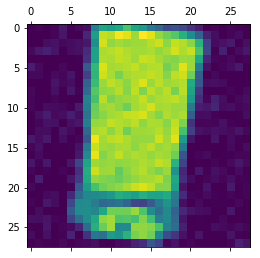

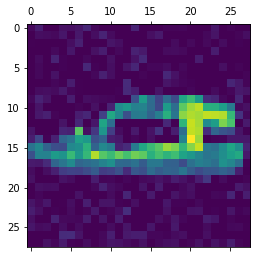

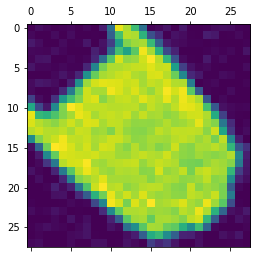

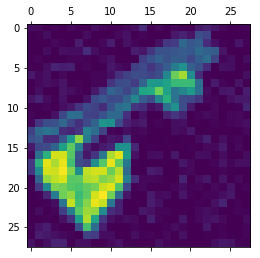

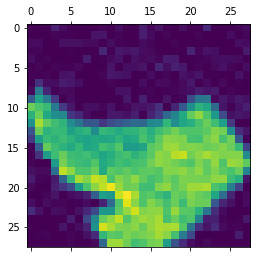

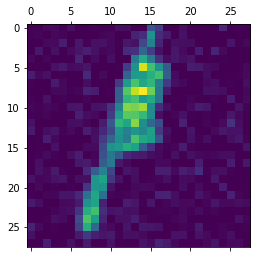

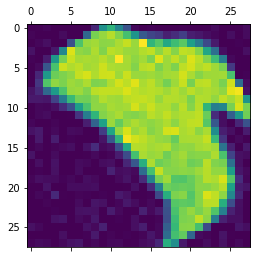

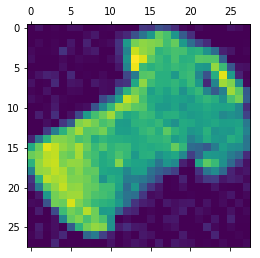

In [203]:
pos = Xnormalized[Ytrain == 1]
neg = Xnormalized[Ytrain == -1]
for i in range(10,14): 
    image_pos = np.reshape(pos[i], (28,28))
    image_neg = np.reshape(neg[i], (28,28))
    plt.matshow(image_pos)
    plt.matshow(image_neg)

### ii) 

There are 1821 negatives and 1179 positive labels. Thus, the data is moderately imbalanced with a rough 60/40 split (dominated by negatives).

In [16]:
np.unique(Ytrain, return_counts=True)

(array([-1.,  1.]), array([1821, 1179]))

### iii)


Due to the imbalance of the data, accuracy seems to be not the most appropriate performace evaluation tool owing to its bias toward the dominant category. Thus, AUC-ROC or AUC-PR are prefered options. The choice among these two metrics depends on the severity of the imbalance and the weight we put on correctly predicting the positive class (and thus precision). Since (1) the skew of the data is not severe (60/40), (2) no information is given about the goals of prediction and the fact that (3) the nature of the data (clothing) does not suggest that False Positives or False Negatives are more costly, I decided to use AUC-ROC as the performace evaluation metric. 

### iv)

In general, a random classifier is expected to predict 50% of the labels correctly, yet we could derive a slightly more sphisticated expectation of the random classifier which would allow to incorporate different rates of predicting a certain group (predicting everything is of one class is as random as predicting 50/50 split). Accuracy is defined as a ratio of correctly labeled instances (True positives + True negetives) to the total population. To calculate expected confussion matrix terms, let's define $q$ as a probability that a random classifier assigns a positive label to a random input. In addition, recall that our traiingn data has 60% of negative and 40% of positive indtances. Then the expected proportions of all the confussion matrix terms are:

$TP = 0.4q \\
TN = (1-q)0.6 \\
FP = 0.6q\\
FN = (1-q)0.4$

Hence the expected accuracy of a random classifier is $TP+TN = 0.6-0.2q$, which for $q=0.5$ results in accuracy being 50%. 

### v)

AUC-ROC curve is defined as the are under the true positive rate (TPR) against the false positive rate (FPR) curve. 

$TPR = \frac{TP}{FN+TP}= \frac{0.4q}{(1-q)0.4+0.4}=q \\
FPR = \frac{FP}{FP+TN}= \frac{0.6q}{(1-q)0.6+0.6}=q$

Hence the expectation of TPR over the range of FPR is:

$\int_0^1qdq=\frac{q^2}{2}|_0^1=1/2$

And since the expected AUC-ROC does not depend on the proportion of the data, the same result holds for the testing data.

AUC-PR, on the other hand is defined as the are under the precisiona against TPR curve. For the testing data is follows that:

$Precision = \frac{TP}{TP+FP}=\frac{0.4q}{0.4q+0.6q}=0.4$

Hence the expected training AUC-PR is

$\int_0^10.4qd=0.4q|_0^1 = 0.4$

By the same reasoning, it follows that expected random classifier AUC-PR for the testing data would be equal to the proportion of positive items in a data.

## Question 2
### i)

In [4]:
sknn = KNeighborsClassifier(n_neighbors=1)

skf = StratifiedKFold(n_splits=5)

# function that gives accuracy after fitting the model via cross validation
scores = cross_val_score(sknn, Xtrain, Ytrain, cv=skf)

In [211]:
# Accuracy summary
print(scores)

[0.77703827 0.75333333 0.74166667 0.75833333 0.73789649]


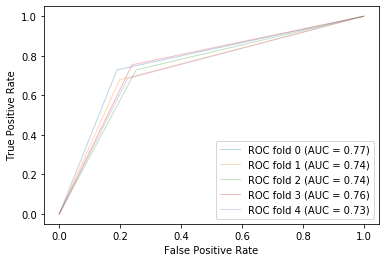

In [210]:
# AUC-ROC for each fold sklearn 22.1 only
aucs = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    # requires sklearn 22.1
    viz = plot_roc_curve(sknn, Xtrain[test], Ytrain[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    aucs.append(viz.roc_auc) 

Fold  0 AUC ROC: 0.7696265598807971
Fold  1 AUC ROC: 0.7400819519463588
Fold  2 AUC ROC: 0.7380331532873905
Fold  3 AUC ROC: 0.7576131495623021
Fold  4 AUC ROC: 0.730224424366074
Fold-Wise AUC [0.7696265598807971, 0.7400819519463588, 0.7380331532873905, 0.7576131495623021, 0.730224424366074]
Mean AUC 0.7471158478085845
Stdev AUC 0.014382049358744492


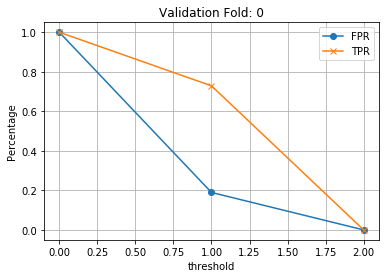

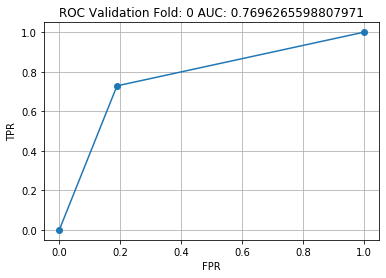

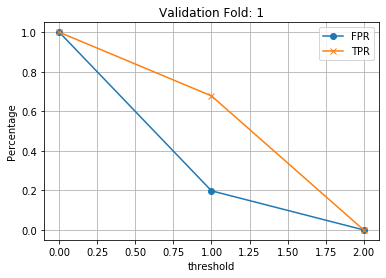

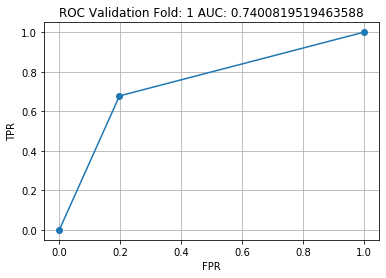

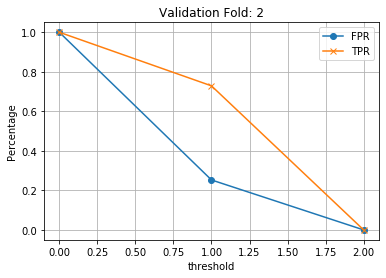

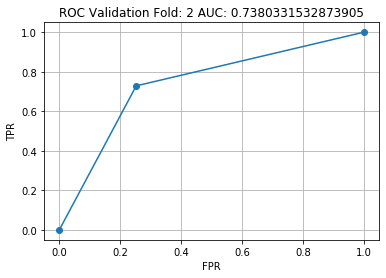

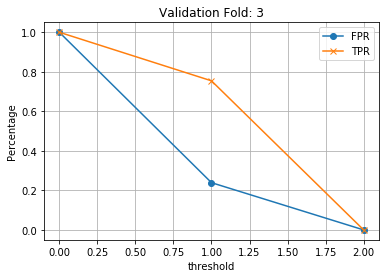

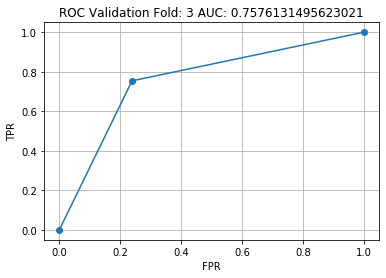

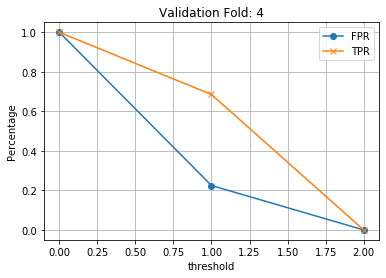

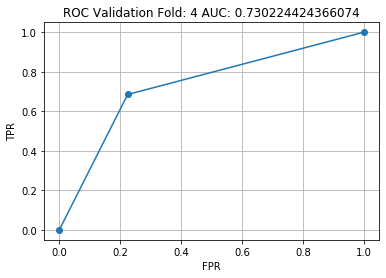

In [209]:
# alternative for lower sklearn versions

A = []
for i,(tr_idx, v_idx) in enumerate(skf.split(Xtrain, Ytrain)):
    Xtr, Xv = Xtrain[tr_idx], Xtrain[v_idx]
    ytr, yv = Ytrain[tr_idx], Ytrain[v_idx] 
    sknn.fit(Xtr,ytr)
    z = sknn.predict_proba(Xv)[:,1]
    roc_auc = plotROC(yv,z,pstr = 'Validation Fold: '+str(i))
    A.append(roc_auc)
    print('Fold ',i,'AUC ROC:',roc_auc)

print('Fold-Wise AUC',A)
print('Mean AUC',np.mean(A))
print('Stdev AUC',np.std(A))

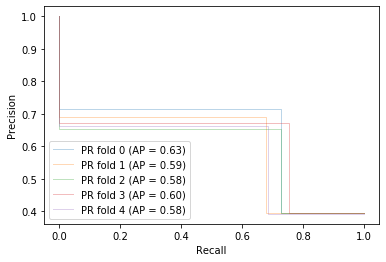

In [200]:
# AUC-PR curve
# requires sklearn 22.1
fig, ax = plt.subplots()
for i, (train, test) in enumerate(skf.split(Xtrain, Ytrain)):
    sknn.fit(Xtrain[train], Ytrain[train])
    viz = plot_precision_recall_curve(sknn, Xtrain[test], Ytrain[test],
                         name='PR fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)

Fold  0 AUC ROC: 0.6268157629462925
Fold  1 AUC ROC: 0.5942294954217806
Fold  2 AUC ROC: 0.5814997431946585
Fold  3 AUC ROC: 0.6032864300181217
Fold  4 AUC ROC: 0.5772515541546274
Fold-Wise AUC [0.6268157629462925, 0.5942294954217806, 0.5814997431946585, 0.6032864300181217, 0.5772515541546274]
Mean AUC 0.5966165971470961
Stdev AUC 0.017695754878847423


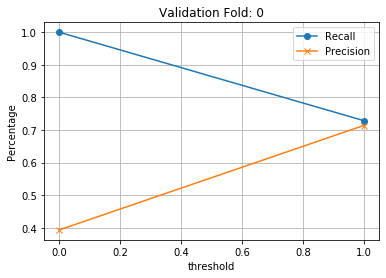

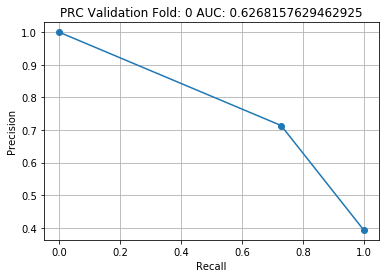

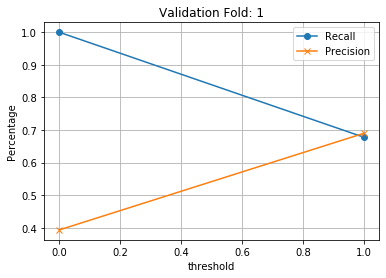

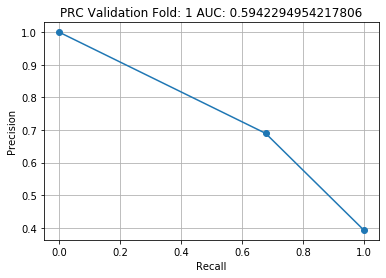

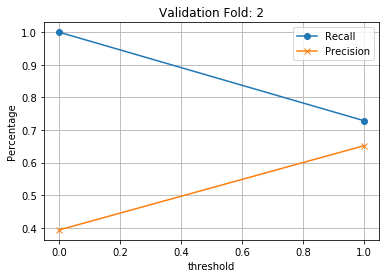

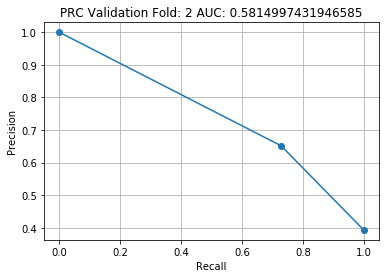

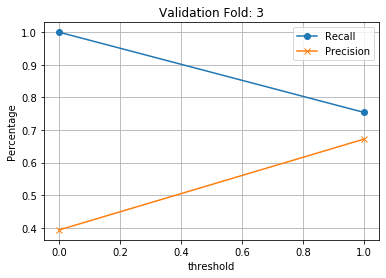

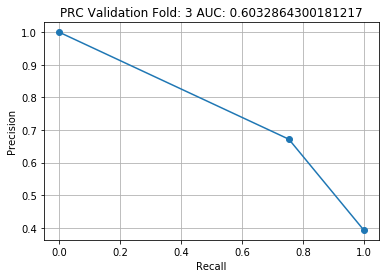

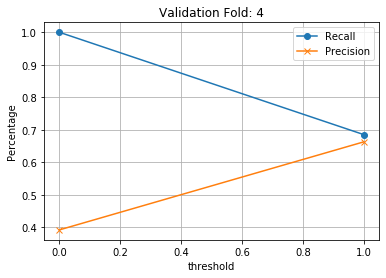

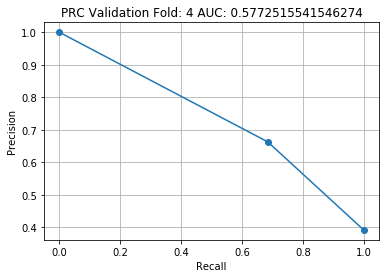

In [213]:
# alternative for lower sklearn versions

A = []
for i,(tr_idx, v_idx) in enumerate(skf.split(Xtrain, Ytrain)):
    Xtr, Xv = Xtrain[tr_idx], Xtrain[v_idx]
    ytr, yv = Ytrain[tr_idx], Ytrain[v_idx] 
    sknn.fit(Xtr,ytr)
    z = sknn.predict_proba(Xv)[:,1]
    roc_auc = plotPRC(yv,z,pstr = 'Validation Fold: '+str(i))
    A.append(roc_auc)
    print('Fold ',i,'AUC ROC:',roc_auc)

print('Fold-Wise AUC',A)
print('Mean AUC',np.mean(A))
print('Stdev AUC',np.std(A))

In [198]:
base_score, base_stds = evaluation_metrics(Xtrain, sknn)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### ii)

In [67]:
# Mean of the evaluation metrics
base_score

{'roc': 0.7471158478085845,
 'pr': 0.5966165971470961,
 'accuracy': 0.7539999999999999}

In [14]:
# Standard deviation for the k = 1 5 Stratified folds
base_stds

roc         0.011321
pr          0.013926
accuracy    0.011265
dtype: float64

### iii)

I will implement the following transformations: scaling, scaling to a range (between 0:1 and -1:1), mapping to uniform and Gaussian distributions and normalization. Sparse data transformations will not be applied because the data is not sparse - all needed values are present. Robust scaling, albeit not neccesary due to the the abscence of strong outliers, will still be conducted to deduce the importance of extreme values.

In [69]:
# Scaling
scaling = preprocessing.StandardScaler().fit(Xtrain)
Xscaled = scaling.transform(Xtrain)

scaled_scores, _ = evaluation_metrics(Xscaled, sknn)

[0.7318401937046004, 0.7423170050288695, 0.764993481095176, 0.7763317191283293, 0.7461964441853688]
AUC-ROC: 0.75 (+/- 0.03)
[0.5824421972178703, 0.5946940131984997, 0.6166148775894539, 0.6276427153545798, 0.5972080773910206]
AUC-PR: 0.60 (+/- 0.03)
[0.7433333333333333, 0.7533333333333333, 0.77, 0.7783333333333333, 0.7566666666666667]
Accuracy: 0.76 (+/- 0.02)


In [72]:
scaled_scores

{'roc': 0.7523357686284688,
 'pr': 0.6037203761502848,
 'accuracy': 0.7603333333333333}

In [74]:
# MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
Xtrain_minmax = min_max_scaler.fit_transform(Xtrain)

minmax_scores, _ = evaluation_metrics(Xtrain_minmax, sknn)
# AUC-ROC same as scaled, AUC-PR worse, accuracy -worse. Prefer scaled

[0.7626420189979511, 0.7387083255727324, 0.7387781709815608, 0.7589867759359284, 0.7294666278053046]
AUC-ROC: 0.75 (+/- 0.03)
[0.6181229341022575, 0.5922227880022308, 0.5817586338728176, 0.6052054442732409, 0.5770173037874106]
AUC-PR: 0.59 (+/- 0.03)
[0.7716666666666666, 0.7516666666666667, 0.74, 0.76, 0.74]
Accuracy: 0.75 (+/- 0.02)


In [75]:
minmax_scores

{'roc': 0.7457163838586955,
 'pr': 0.5948654208075914,
 'accuracy': 0.7526666666666667}

In [76]:
# MaxAbs Scaler - must be centered at zero a priori

demeaning = preprocessing.StandardScaler(with_std=False).fit(Xtrain)
Xdemeaned = scaling.transform(Xtrain)
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain_maxabs = max_abs_scaler.fit_transform(Xdemeaned)

maxabs_scores, _ = evaluation_metrics(Xtrain_maxabs, sknn)
# worse than scaled in all the measures

[0.7481607375675173, 0.7394533432669027, 0.7415254237288136, 0.7589867759359284, 0.7255027688720489]
AUC-ROC: 0.74 (+/- 0.02)
[0.5976955278742087, 0.5923818968626036, 0.5853704417051875, 0.6052054442732409, 0.5701670511834572]
AUC-PR: 0.59 (+/- 0.02)
[0.755, 0.7516666666666667, 0.7433333333333333, 0.76, 0.7333333333333333]
Accuracy: 0.75 (+/- 0.02)


In [77]:
maxabs_scores

{'roc': 0.7427258098742422,
 'pr': 0.5901640723797396,
 'accuracy': 0.7486666666666666}

In [79]:
# Robust Scaling
robust_scaling = preprocessing.RobustScaler().fit(Xtrain)
Xrobust = robust_scaling.transform(Xtrain)

robust_scores, _ = evaluation_metrics(Xrobust, sknn)
# worse in every measure than the scaled version

[0.7101415533618924, 0.7540510337120506, 0.7304665673309741, 0.726462097224809, 0.7413290585835033]
AUC-ROC: 0.73 (+/- 0.03)
[0.558632816240544, 0.6112331969608416, 0.5805351866297899, 0.5735494864932866, 0.591081560283688]
AUC-PR: 0.58 (+/- 0.04)
[0.7233333333333334, 0.7666666666666667, 0.7416666666666667, 0.735, 0.7516666666666667]
Accuracy: 0.74 (+/- 0.03)


In [80]:
robust_scores

{'roc': 0.7324900620426459,
 'pr': 0.58300644932163,
 'accuracy': 0.7436666666666667}

In [81]:
# Uniform distribution transformation

quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
Xuniform = quantile_transformer.fit_transform(Xtrain)

uniform_scores, _ = evaluation_metrics(Xuniform, sknn)
# same or slightly better than scaled. 

[0.7772397094430993, 0.7458092754702924, 0.7461585025144347, 0.7496507729558578, 0.7589332556106092]
AUC-ROC: 0.76 (+/- 0.02)
[0.6378478849166785, 0.5988491667853582, 0.5940222415756683, 0.5980667023961055, 0.602082142479094]
AUC-PR: 0.61 (+/- 0.03)
[0.7866666666666666, 0.7566666666666667, 0.7516666666666667, 0.755, 0.7583333333333333]
Accuracy: 0.76 (+/- 0.03)


In [82]:
uniform_scores

{'roc': 0.7555583031988586,
 'pr': 0.6061736276305809,
 'accuracy': 0.7616666666666666}

In [83]:
normal_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
Xnormal = normal_transformer.fit_transform(Xtrain)

normal_scores, _ = evaluation_metrics(Xnormal, knn)
# worse than scaled or uniform 

[0.7273002421307506, 0.7206183646861613, 0.7334932017135407, 0.7296051406220898, 0.7633925969105216]
AUC-ROC: 0.73 (+/- 0.03)
[0.554144388990463, 0.5424317203828928, 0.5560993982821185, 0.5508592894962582, 0.5863306508971936]
AUC-PR: 0.56 (+/- 0.03)
[0.7016666666666667, 0.68, 0.6983333333333334, 0.69, 0.7333333333333333]
Accuracy: 0.70 (+/- 0.04)


In [84]:
normal_scores

{'roc': 0.7348819092126128,
 'pr': 0.5579730896097852,
 'accuracy': 0.7006666666666667}

In [86]:
Xnormalized = preprocessing.normalize(Xtrain, norm='l2')

normalized_scores,_ = evaluation_metrics(Xnormalized, sknn)
# highest AUC-ROC, slightly lower accuracy than that of uniform.

[0.7849227044142297, 0.7641320543862917, 0.7537250884708513, 0.7497671819705717, 0.7209268434858642]
AUC-ROC: 0.75 (+/- 0.04)
[0.6345537144784551, 0.6183235328029516, 0.5948774539690282, 0.5965418473262383, 0.5622476813966175]
AUC-PR: 0.60 (+/- 0.05)
[0.7833333333333333, 0.7716666666666666, 0.75, 0.7533333333333333, 0.725]
Accuracy: 0.76 (+/- 0.04)


In [87]:
normalized_scores

{'roc': 0.7546947745455618,
 'pr': 0.6013088459946582,
 'accuracy': 0.7566666666666666}

In [17]:
Xnormalized = preprocessing.normalize(Xtrain, norm='l2')

array([[0.00076317, 0.        , 0.00686855, ..., 0.        , 0.        ,
        0.        ],
       [0.00121765, 0.00267883, 0.00024353, ..., 0.00073059, 0.        ,
        0.00073059],
       [0.        , 0.00187817, 0.        , ..., 0.        , 0.00037563,
        0.00037563],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00121983,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00134678, ..., 0.02397266, 0.01292908,
        0.00107742]])

array([[ 1.,  0.,  9., ...,  0.,  0.,  0.],
       [ 5., 11.,  1., ...,  3.,  0.,  3.],
       [ 0.,  5.,  0., ...,  0.,  1.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  4.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ..., 89., 48.,  4.]])

NOrmalisarion to have unit norm, scaling and mapping the data to uniform distribution seems to have led to the highest AUC-ROC score. However, only normalised training data managed to improve AUC-ROC score, which I hold to be the most approporiate measure. Thus, I will will focus on normalisation.

In [289]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []
cv_std = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    means, stds = evaluation_metrics(X = Xnormalized, classifier = knn, print_summary = False)
    means['k'] = k
    stds['k'] = k
    cv_scores.append(means)
    cv_std.append(stds)

In [290]:
normalized_k = pd.DataFrame(cv_scores)
normalized_k_stds = pd.DataFrame(cv_std)

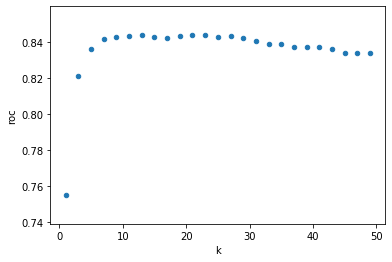

In [291]:
normalized_k.plot.scatter(y='roc', x = 'k')

In [292]:
# finding the best k according to roc
normalized_k.loc[normalized_k['roc'] == normalized_k['roc'].max(), 'k']

11    23
Name: k, dtype: int64

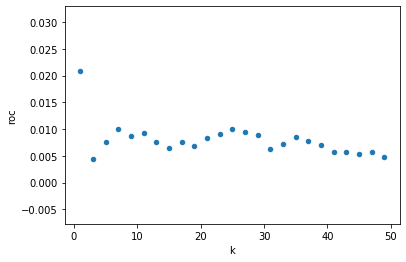

In [293]:
# checking its standard deviation
normalized_k_stds.plot.scatter(y='roc', x = 'k')

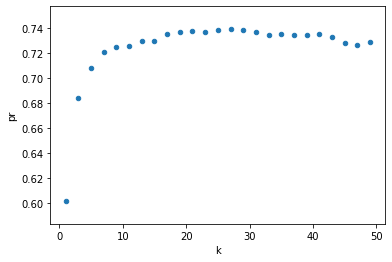

In [294]:
normalized_k.plot.scatter(y='pr', x = 'k')

# follows ROC_AUC, as it should

13    27
Name: k, dtype: int64

2    5
Name: k, dtype: int64

In [297]:
# Choosing k=23 with ROC-AUC score of

normalized_k['roc'].max()

0.8440297074991264

In [298]:
# creating odd list of K for KNN
neighbors = list(range(10, 26, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    means, stds = evaluation_metrics(X = Xnormalized, classifier = knn, print_summary = False)
    means['k'] = k
    stds['k'] = k
    cv_scores_zoom.append(means)
    cv_std_zoom.append(stds)

In [299]:
normalized_k_zoom = pd.DataFrame(cv_scores_zoom)
normalized_k_zoom_std = pd.DataFrame(cv_std_zoom)

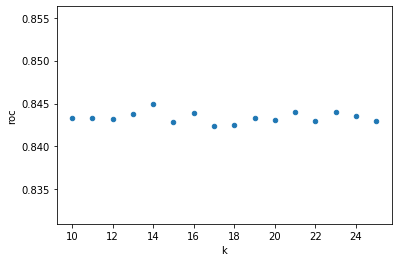

In [300]:
normalized_k_zoom.plot.scatter(y='roc', x ='k')
# 14 is the highest

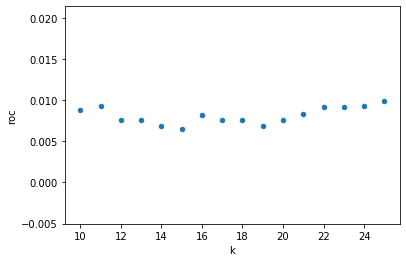

In [301]:
normalized_k_zoom_std.plot.scatter(y='roc', x ='k')
# even visually k=14 seen that k=14 has lower variance than the closest contenders k=21, k=23

In [302]:
normalized_k_zoom.loc[normalized_k_zoom['roc'] == normalized_k_zoom['roc'].max(), 'k']

4    14
Name: k, dtype: int64

In [303]:
normalized_k_zoom_std.loc[normalized_k_zoom_std['roc'] == normalized_k_zoom_std['roc'].min(), 'k']

5    15
Name: k, dtype: int64

In [304]:
# accuracy, AUC-ROC and AUC-PR for k=14
normalized_k_zoom.loc[normalized_k_zoom['k'] == 14]

,roc,pr,accuracy,k
4,0.844895,0.733108,0.754,14


## Question 3

### Perceptron

In [249]:
perceptron = Perceptron(random_state = 10)

perceptron_scores, perceptron_stds = evaluation_metrics(X=Xnormalized, classifier = perceptron, 
                                                        has_decision_function = True)
# pretty horrible

[0.7613149562302104, 0.7516180853045259, 0.7532594524119948, 0.7882170795306388, 0.7876420868551444]
AUC-ROC: 0.77 (+/- 0.03)
[0.5991893633708482, 0.586648163900361, 0.5922122548156856, 0.6419288500014452, 0.6151927769188795]
AUC-PR: 0.61 (+/- 0.04)
[0.66, 0.65, 0.6633333333333333, 0.71, 0.6516666666666666]
Accuracy: 0.67 (+/- 0.04)


In [250]:
perceptron = Perceptron(random_state = 10)

perceptron_scores, perceptron_stds = evaluation_metrics(X=Xuniform, classifier = perceptron,
                                                       has_decision_function = True)
# pretty horrible

[0.7799753212888805, 0.7341916558018253, 0.7346805736636244, 0.7655406034643323, 0.7932148061789567]
AUC-ROC: 0.76 (+/- 0.05)
[0.6431515802503611, 0.5795536158671164, 0.5920116545380093, 0.6053094029613515, 0.6348150502047467]
AUC-PR: 0.61 (+/- 0.05)
[0.6383333333333333, 0.6383333333333333, 0.6366666666666667, 0.6916666666666667, 0.6416666666666667]
Accuracy: 0.65 (+/- 0.04)


In [251]:
perceptron = Perceptron(random_state = 10)

perceptron_scores, perceptron_stds = evaluation_metrics(X=Xscaled, classifier = perceptron,
                                                       has_decision_function = True)
# pretty horrible

[0.5705322220152729, 0.7453319985099647, 0.7317703482957719, 0.78211724715962, 0.7814398134654621]
AUC-ROC: 0.72 (+/- 0.16)
[0.45265810628608094, 0.6054872331026796, 0.595570755751029, 0.6408373482817213, 0.6354019768352962]
AUC-PR: 0.59 (+/- 0.14)
[0.575, 0.6783333333333333, 0.6583333333333333, 0.7016666666666667, 0.7116666666666667]
Accuracy: 0.67 (+/- 0.10)


## Linear Support Vector Machine

In [125]:
# Looking for C and the right kernel

parameters = [{'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [0.01, 0.1, 1, 10, 100]},
              {'kernel': ['rbf'], 'gamma': [1e-2, 1e-4, 1, 10], 'C': [0.01, 0.1, 1, 10, 100]},
            {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]}]

svc = SVC(class_weight = 'balanced')
clf = GridSearchCV(svc, parameters, scoring = 'roc_auc')
clf.fit(Xnormalized, Ytrain)

[0.7584978580741293, 0.7373812628049916, 0.7289066865338051, 0.7319333209163719, 0.7717575051005537]
AUC-ROC: 0.75 (+/- 0.03)
[0.5864175192141293, 0.5616162000888719, 0.5542963533641501, 0.5603160098019195, 0.5949902176571289]
AUC-PR: 0.57 (+/- 0.03)
[0.735, 0.7066666666666667, 0.7, 0.71, 0.7416666666666667]
Accuracy: 0.72 (+/- 0.03)


In [274]:
res = pd.DataFrame(clf.cv_results_)

In [275]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.039074,0.539932,1.084443,0.137824,0.01,2,poly,NaN,"{'C': 0.01, 'degree': 2, 'kernel': 'poly'}",0.794189,0.786937,0.784608,0.809078,0.800874,0.795137,0.009014,30
1,5.215988,0.705980,1.322391,0.175880,0.01,3,poly,NaN,"{'C': 0.01, 'degree': 3, 'kernel': 'poly'}",0.825037,0.813606,0.817948,0.840322,0.824926,0.824368,0.009081,24
2,4.445880,0.304706,1.029146,0.195053,0.01,4,poly,NaN,"{'C': 0.01, 'degree': 4, 'kernel': 'poly'}",0.841754,0.838366,0.840974,0.861054,0.844360,0.845302,0.008105,18
3,3.967206,0.421596,0.909293,0.283934,0.01,5,poly,NaN,"{'C': 0.01, 'degree': 5, 'kernel': 'poly'}",0.849576,0.854931,0.855339,0.870833,0.856543,0.857444,0.007109,12
4,3.526559,0.047837,0.746694,0.035812,0.1,2,poly,NaN,"{'C': 0.1, 'degree': 2, 'kernel': 'poly'}",0.839297,0.840508,0.837144,0.861392,0.848173,0.845303,0.008862,17
5,4.216654,0.803135,0.864650,0.236323,0.1,3,poly,NaN,"{'C': 0.1, 'degree': 3, 'kernel': 'poly'}",0.851474,0.860100,0.860379,0.875675,0.866185,0.862762,0.007983,9
6,3.320361,0.124268,0.753972,0.125440,0.1,4,poly,NaN,"{'C': 0.1, 'degree': 4, 'kernel': 'poly'}",0.855921,0.868632,0.871426,0.880227,0.873483,0.869938,0.007985,5
7,3.337753,0.297393,0.709501,0.021365,0.1,5,poly,NaN,"{'C': 0.1, 'degree': 5, 'kernel': 'poly'}",0.855723,0.872765,0.872590,0.881333,0.874777,0.871438,0.008475,4
8,3.015586,0.064736,0.629329,0.006944,1,2,poly,NaN,"{'C': 1, 'degree': 2, 'kernel': 'poly'}",0.850112,0.859401,0.864267,0.877375,0.870475,0.864326,0.009321,8
9,2.966673,0.046392,0.632719,0.011793,1,3,poly,NaN,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.846550,0.864092,0.864558,0.877922,0.872201,0.865065,0.010585,6


In [311]:
print(clf.best_params_, "ROC-AUC:", clf.best_score_)

{'C': 10, 'gamma': 10, 'kernel': 'rbf'} ROC-AUC: 0.8759840771196457


In [276]:
parameters_rbf = [{'kernel': ['rbf'], 'gamma': [10, 100, 1000], 'C': [0.01, 0.1, 1, 10, 100]}]

clf_rbf = GridSearchCV(svc, parameters_rbf, scoring = 'roc_auc')
clf_rbf.fit(Xnormalized, Ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [10, 100, 1000], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [277]:
res_rbf = pd.DataFrame(clf_rbf.cv_results_)

In [278]:
res_rbf
# RBF gamma = 10, C=10 is still the best followed by gamma = 10, C=100

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.910848,0.657235,1.240100,0.023355,0.01,10,rbf,"{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}",0.788531,0.789579,0.788555,0.814863,0.799813,0.796268,0.010222,5
1,5.381814,0.042042,1.217248,0.009867,0.01,100,rbf,"{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}",0.811627,0.779940,0.785115,0.778561,0.739539,0.778957,0.023066,10
2,6.983186,1.390937,2.157558,1.006919,0.01,1000,rbf,"{'C': 0.01, 'gamma': 1000, 'kernel': 'rbf'}",0.530220,0.533491,0.540825,0.530802,0.531758,0.533419,0.003865,15
3,6.282929,0.781535,1.277291,0.142581,0.1,10,rbf,"{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}",0.801767,0.805318,0.806342,0.830089,0.813314,0.811366,0.010083,4
4,6.006784,0.408645,1.395301,0.105911,0.1,100,rbf,"{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}",0.812488,0.779999,0.785202,0.778340,0.739539,0.779114,0.023317,9
5,5.497036,0.390978,1.371293,0.121710,0.1,1000,rbf,"{'C': 0.1, 'gamma': 1000, 'kernel': 'rbf'}",0.532280,0.536855,0.544148,0.536087,0.538496,0.537573,0.003868,14
6,6.708677,2.322383,1.415333,0.319692,1,10,rbf,"{'C': 1, 'gamma': 10, 'kernel': 'rbf'}",0.864092,0.871845,0.869238,0.879982,0.876176,0.872267,0.005495,3
7,7.288317,1.933161,1.405328,0.124197,1,100,rbf,"{'C': 1, 'gamma': 100, 'kernel': 'rbf'}",0.812098,0.778474,0.787059,0.780895,0.740006,0.779706,0.023162,8
8,6.949640,2.395789,1.322160,0.037066,1,1000,rbf,"{'C': 1, 'gamma': 1000, 'kernel': 'rbf'}",0.533601,0.540190,0.553467,0.545440,0.538496,0.542239,0.006769,11
9,6.297954,0.664606,1.397069,0.237845,10,10,rbf,"{'C': 10, 'gamma': 10, 'kernel': 'rbf'}",0.871077,0.878970,0.877887,0.878492,0.873495,0.875984,0.003134,1


In [365]:
# setting RBF, gamma = 10, C=10 to get full score breakdown

RBF_SVM = SVC(C = 10 , class_weight = 'balanced', kernel = 'rbf', gamma = 10)

RBF_scores, RBF_stds = evaluation_metrics(Xnormalized, classifier = RBF_SVM, has_decision_function = True)

[0.5234214937604768, 0.5294165580182529, 0.5348237567517228, 0.5267275097783573, 0.5289303410084524]
AUC-ROC: 0.53 (+/- 0.01)
[0.41393724232707285, 0.41538439289639617, 0.42111400840214397, 0.414043583535109, 0.4181373078446196]
AUC-PR: 0.42 (+/- 0.01)
[0.6166666666666667, 0.615, 0.6183333333333333, 0.615, 0.6216666666666667]
Accuracy: 0.62 (+/- 0.00)


In [287]:
RBF_scores

{'roc': 0.8759840771196457,
 'pr': 0.7950268358072782,
 'accuracy': 0.7963333333333333}

In [288]:
RBF_stds

{'roc': 0.003133741235300407,
 'pr': 0.008070402959498362,
 'accuracy': 0.009510228411791397}

### Logistic Regression

In [339]:
logistic = LogisticRegression(max_iter=1000)

#logistic_scores, logistic_stds = evaluation_metrics(Xnormalized, classifier = logistic, has_decision_function = True)

In [363]:
# Grid search for C

parameters_logistic = [{'C': [0.01, 0.1, 1, 10, 100]}]

clf_logistic = GridSearchCV(logistic, parameters_logistic, scoring = 'roc_auc')
clf_logistic.fit(Xnormalized, Ytrain)

/Users/MacBook_Retina_2015_256Gb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [334]:
res_logistic = pd.DataFrame(clf_logistic.cv_results_)
res_logistic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049309,0.014367,0.003867,0.001460,0.01,{'C': 0.01},0.766612,0.753062,0.740617,0.769871,0.776240,0.761280,0.012810,5
1,0.047800,0.002849,0.002099,0.000071,0.1,{'C': 0.1},0.774213,0.759359,0.750210,0.783246,0.783352,0.770076,0.013239,4
2,0.149180,0.070593,0.002799,0.000934,1,{'C': 1},0.789183,0.773107,0.765343,0.803653,0.792585,0.784774,0.013788,2
3,0.384418,0.082043,0.002687,0.000731,10,{'C': 10},0.799031,0.778252,0.772711,0.804456,0.799021,0.790694,0.012700,1
4,1.122653,0.041315,0.002517,0.000872,100,{'C': 100},0.779801,0.772071,0.745635,0.773701,0.800816,0.774405,0.017665,3


In [364]:
print(clf_logistic.best_params_, "ROC-AUC:", clf_logistic.best_score_)

{'C': 0.01} ROC-AUC: 0.7855951980504466


### Naive Bayes

In [352]:
prior = np.array([1821/3000, 1179/3000] )

In [353]:
gaus_bayes = GaussianNB(priors = prior)

gaus_bayes_score, gaus_bayes_stds = evaluation_metrics(Xnormalized, classifier = gaus_bayes)

[0.7339355559694543, 0.7229058018252934, 0.7167419444961819, 0.7401052337493015, 0.7372602739726027]
AUC-ROC: 0.73 (+/- 0.02)
[0.5506431666247389, 0.5451873351132425, 0.5399641615031079, 0.5641490235298481, 0.5605619026678912]
AUC-PR: 0.55 (+/- 0.02)
[0.6533333333333333, 0.6516666666666666, 0.6316666666666667, 0.6633333333333333, 0.66]
Accuracy: 0.65 (+/- 0.02)


In [355]:
comp_bayes = ComplementNB()

comp_bayes_score, comp_bayes_stds = evaluation_metrics(Xnormalized, classifier = comp_bayes)

[0.7462865524306201, 0.7308157943751163, 0.7215030731979885, 0.7170795306388528, 0.7545205479452054]
AUC-ROC: 0.73 (+/- 0.03)
[0.5726752031074744, 0.5310549942627283, 0.5216143369035231, 0.517331673223913, 0.5761232677320136]
AUC-PR: 0.54 (+/- 0.05)
[0.6733333333333333, 0.6883333333333334, 0.6733333333333333, 0.675, 0.6866666666666666]
Accuracy: 0.68 (+/- 0.01)


In [357]:
ber_bayes = BernoulliNB()

ber_bayes_score, ber_bayes_stds = evaluation_metrics(Xnormalized, classifier = ber_bayes)

[0.7447033898305084, 0.7274864965542931, 0.7275563419631216, 0.7535737567517228, 0.7560361410667443]
AUC-ROC: 0.74 (+/- 0.02)
[0.5809688106894698, 0.5431688451750721, 0.5532249011336461, 0.5988707197669176, 0.5910271651020911]
AUC-PR: 0.57 (+/- 0.04)
[0.6616666666666666, 0.65, 0.63, 0.6566666666666666, 0.6683333333333333]
Accuracy: 0.65 (+/- 0.03)


In [360]:
multi_bayes = MultinomialNB()

multi_bayes_score, multi_bayes_stds = evaluation_metrics(Xnormalized, classifier = multi_bayes)

[0.7462865524306201, 0.7308157943751163, 0.7215030731979885, 0.7170795306388528, 0.7545205479452054]
AUC-ROC: 0.73 (+/- 0.03)
[0.5726752031074744, 0.5310549942627283, 0.5216143369035231, 0.517331673223913, 0.5761232677320136]
AUC-PR: 0.54 (+/- 0.05)
[0.6733333333333333, 0.6883333333333334, 0.6733333333333333, 0.675, 0.6866666666666666]
Accuracy: 0.68 (+/- 0.01)


[0.72333333 0.76666667 0.74166667 0.735      0.75166667]
Accuracy: 0.74 (+/- 0.03)
0.7436666666666667 0.014734690736866903


[0.78666667 0.75666667 0.75166667 0.755      0.75833333]
Accuracy: 0.76 (+/- 0.03)
0.7616666666666666 0.012692955176439823


[0.64333333 0.66833333 0.65666667 0.67166667 0.665     ]
Accuracy: 0.66 (+/- 0.02)
0.6609999999999999 0.010143416036468634


[0.77833333 0.75333333 0.74       0.75833333 0.74      ]
Accuracy: 0.75 (+/- 0.03)
0.7539999999999999 0.01416568624058385


[0.78333333 0.77166667 0.75       0.75333333 0.725     ]


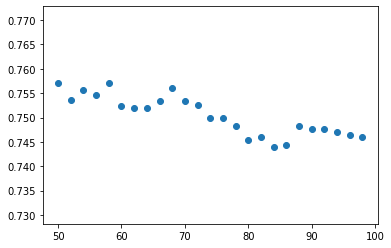

In [99]:
zip(*cv_scores_next)
plt.scatter(*zip(*cv_scores_next))
plt.show()

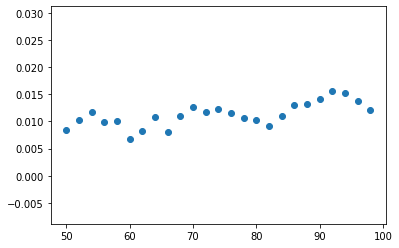

In [100]:
zip(*cv_std_next)
plt.scatter(*zip(*cv_std_next))
plt.show()

In [106]:
print(cv_scores)

[(1, 0.7603333333333333), (3, 0.7516666666666667), (5, 0.7619999999999999), (7, 0.7699999999999999), (9, 0.7656666666666666), (11, 0.7676666666666667), (13, 0.772), (15, 0.7683333333333333), (17, 0.7653333333333332), (19, 0.764), (21, 0.765), (23, 0.7673333333333334), (25, 0.7673333333333334), (27, 0.7633333333333334), (29, 0.7633333333333333), (31, 0.7656666666666666), (33, 0.7623333333333333), (35, 0.7606666666666666), (37, 0.7643333333333333), (39, 0.767), (41, 0.7653333333333333), (43, 0.764), (45, 0.7596666666666666), (47, 0.7586666666666666), (49, 0.7596666666666667)]


Test 12 and 14 now. k=3 seems to be the best

In [107]:
# creating odd list of K for KNN
neighbors = list(range(12, 15, 1))

# empty list that will hold cv scores
cv_scores_mid = []
cv_std_mid = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_mid.append((k,scores.mean()))
    cv_std_mid.append((k,scores.std()))

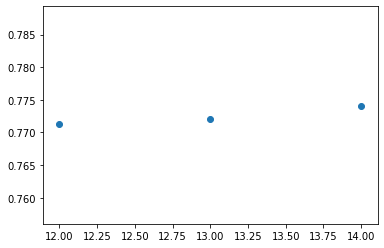

[(12, 0.7713333333333333), (13, 0.772), (14, 0.774)]


In [109]:
zip(*cv_scores_mid)
plt.scatter(*zip(*cv_scores_mid))
plt.show()
print(cv_scores_mid)

so choose k=14

In [13]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores_def = []
cv_std_def = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_def.append((k,scores.mean()))
    cv_std_def.append((k,scores.std()))

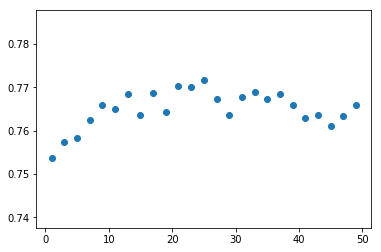

[(1, 0.7536536194082021), (3, 0.7573208314467539), (5, 0.7583297314714763), (7, 0.7623291823958771), (9, 0.7659947435039172), (11, 0.7649952907276595), (13, 0.7683319666628704), (15, 0.7636652944406327), (17, 0.7686630833233796), (19, 0.7643314175872711), (21, 0.7703303064730735), (23, 0.7699941981320318), (25, 0.7716569749730786), (27, 0.767329193507019), (29, 0.7636664074066872), (31, 0.767663630547122), (33, 0.7689964092492849), (35, 0.7673330777770679), (37, 0.7683314064761292), (39, 0.7659969620285982), (41, 0.762996401841857), (43, 0.7636641759190071), (45, 0.760996398138143), (47, 0.7633319574035854), (49, 0.7660008500023612)]


In [14]:
zip(*cv_scores_def)
plt.scatter(*zip(*cv_scores_def))
plt.show()
print(cv_scores_def)

In [15]:
# creating odd list of K for KNN
neighbors = list(range(19, 28, 1))

# empty list that will hold cv scores
cv_scores_zoom = []
cv_std_zoom = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xscale, Ytrain, cv=skf, scoring='accuracy')
    cv_scores_zoom.append((k,scores.mean()))
    cv_std_zoom.append((k,scores.std()))

In [21]:
print(perceptron_scores)

[0.67387687 0.605      0.575      0.645      0.67445743]


In [35]:
LSVM.fit(Xscale,Ytrain)
Ypredict = LSVM.predict(Xscale)

print( "Train Accuracy", np.mean(Ypredict==Ytrain))

Train Accuracy 0.8663333333333333


In [36]:
LSVMscore = cross_val_score(LSVM, Xscale, Ytrain, cv=5)
print(LSVMscore)

[0.65723794 0.66333333 0.64166667 0.67       0.71452421]


In [ ]:
polySVM = SVC(C = 1, kernel = 'poly', degree = 2,  class_weight = 'balanced', coef0 = 1.0)

polySVM_score = cross_val_score(polySVM, Xscale, Ytrain, cv = 5)

In [13]:
print(polySVM_score)
polySVM_score.mean()

[0.78369384 0.77833333 0.79       0.77166667 0.78964942]


0.7826686518573662

In [14]:
polySVM4 = SVC(C = 1, kernel = 'poly', degree = 4,  class_weight = 'balanced', coef0 = 1.0)

polySVM4_score = cross_val_score(polySVM4, Xscale, Ytrain, cv = 5)

/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/local/java/python-pip-packages.cs909/lib64/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/loc

In [15]:
print(polySVM4_score)
polySVM4_score.mean()

[0.77204659 0.77333333 0.77833333 0.77833333 0.78964942]


0.7783392009422248